线性回归

In [22]:
#首先我们引入必要的库：
from __future__ import print_function
import paddle
import paddle.fluid as fluid
import numpy
import math
import sys
import six.moves

接下来我们定义了用于训练的数据提供器。提供器每次读入一个大小为BATCH_SIZE的数据批次。
如果用户希望加一些随机性，它可以同时定义一个批次大小和一个缓存大小。
这样的话，每次数据提供器会从缓存中随机读取批次大小那么多的数据。

In [23]:
import paddle.dataset.uci_housing
BATCH_SIZE = 20

train_reader = paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.uci_housing.train(), buf_size=500),
        batch_size=BATCH_SIZE)

test_reader = paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.uci_housing.test(), buf_size=500),
        batch_size=BATCH_SIZE)

In [11]:
BATCH_SIZE = 20
#如果想直接从txt文件中读取数据的话，可以参考以下方式
feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'convert' ]
feature_num = len(feature_names)

data = numpy.fromfile('housing.txt', sep=' ') # 从文件中读取原始数据
print(data.shape)
data = data.reshape(data.shape[0] // feature_num, feature_num)

maximums, minimums, avgs = data.max(axis=0), data.min(axis=0), data.sum(axis=0)/data.shape[0]

for i in six.moves.range(feature_num-1): data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i]) # six.moves可以兼容python2和python3

ratio = 0.8 # 训练集和验证集的划分比例

offset = int(data.shape[0]*ratio)

train_data = data[:offset]

test_data = data[offset:]

train_reader = paddle.batch( paddle.reader.shuffle( train_data, buf_size=500), batch_size=BATCH_SIZE)

test_reader = paddle.batch( paddle.reader.shuffle( test_data, buf_size=500), batch_size=BATCH_SIZE)

(7084,)


In [12]:
print(test_data)

[[ 0.42616306 -0.11363636  0.25525005 ... -0.0686218   0.40637243
   8.5       ]
 [ 0.72279828 -0.11363636  0.25525005 ...  0.07134996  0.28495962
   5.        ]
 [ 0.19222996 -0.11363636  0.25525005 ...  0.03415696  0.2948934
  11.9       ]
 ...
 [-0.03993221 -0.11363636  0.02907703 ...  0.10143217 -0.1935172
  23.9       ]
 [-0.03938337 -0.11363636  0.02907703 ...  0.09273279 -0.17033839
  22.        ]
 [-0.04008226 -0.11363636  0.02907703 ...  0.10143217 -0.13170704
  11.9       ]]


配置训练程序

训练程序的目的是定义一个训练模型的网络结构。对于线性回归来讲，它就是一个从输入到输出的简单的全连接层。更加复杂的结果，比如卷积神经网络，递归神经网络等会在随后的章节中介绍。训练程序必须返回平均损失作为第一个返回值，因为它会被后面反向传播算法所用到。

In [24]:
x = fluid.layers.data(name='x', shape=[13], dtype='float32')# 定义输入的形状和数据类型
y= fluid.layers.data(name='y', shape=[1], dtype='float32')# 定义输出的形状和数据类型
y_predict = fluid.layers.fc(input=x, size=1, act=None)# # 连接输入和输出的全连接层

# 获取默认/全局主函数
main_program = fluid.default_main_program()
# 获取默认/全局启动程序
startup_program = fluid.default_startup_program()

# 利用标签数据和输出的预测数据估计方差
cost = fluid.layers.square_error_cost(input=y_predict, label=y)
# 对方差求均值，得到平均损失
avg_loss = fluid.layers.mean(cost)

Optimizer Function 配置

在下面的 SGD optimizer，learning_rate 是学习率，与网络的训练收敛速度有关系。

In [25]:
sgd_optimizer = fluid.optimizer.SGD(learning_rate=0.001)
sgd_optimizer.minimize(avg_loss)

#克隆main_program得到test_program
#有些operator在训练和测试之间的操作是不同的，例如batch_norm，使用参数for_test来区分该程序是用来训练还是用来测试
#该api不会删除任何操作符,请在backward和optimization之前使用
test_program = main_program.clone(for_test=True)

定义运算场所

我们可以定义运算是发生在CPU还是GPU

In [26]:
use_cuda = False
# 指明executor的执行场所
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

###executor可以接受传入的program，并根据feed map(输入映射表)和fetch list(结果获取表)向program中添加数据输入算子和结果获取算子。使用close()关闭该executor，调用run(...)执行program。
exe = fluid.Executor(place)

创建训练过程

训练需要有一个训练程序和一些必要参数，并构建了一个获取训练过程中测试误差的函数。必要参数有executor,program,reader,feeder,fetch_list，executor表示之前创建的执行器，program表示执行器所执行的program，是之前创建的program，如果该项参数没有给定的话则默认使用defalut_main_program，reader表示读取到的数据，feeder表示前向输入的变量，fetch_list表示用户想得到的变量或者命名的结果。

In [30]:
num_epochs = 100

def train_test(executor, program, reader, feeder, fetch_list):
    accumulated = 1 * [0]
    count = 0
    for data_test in reader():
        outs = executor.run(program=program,
                            feed=feeder.feed(data_test),
                            fetch_list=fetch_list)
        accumulated = [x_c[0] + x_c[1][0] for x_c in zip(accumulated, outs)] # 累加测试过程中的损失值
        count += 1 # 累加测试集中的样本数量
    return [x_d / count for x_d in accumulated] # 计算平均损失
        

训练主循环

给出需要存储的目录名，并初始化一个执行器。

In [31]:
%matplotlib inline
params_dirname = "fit_a_line.inference.model"
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])
exe.run(startup_program)
train_prompt = "train cost"
test_prompt = "test cost"
from paddle.utils.plot import Ploter
plot_prompt = Ploter(train_prompt, test_prompt)
step = 0

exe_test = fluid.Executor(place)

paddlepaddle提供了reader机制来读取训练数据。reader会一次提供多列数据，因此我们需要一个python的列表来定义读取顺序。我们构建一个循环来进行训练，直到训练结果足够好或者循环次数足够多。 如果训练迭代次数满足参数保存的迭代次数，可以把训练参数保存到params_dirname。 设置训练主循环

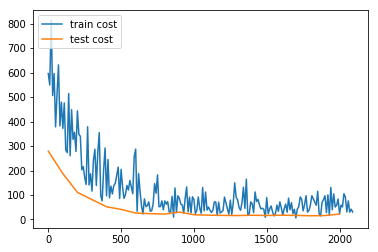

train cost, Step 2090, Cost 30.439896


<Figure size 432x288 with 0 Axes>

In [32]:
for pass_id in range(num_epochs):
    for data_train in train_reader():
        avg_loss_value, = exe.run(main_program,
                                  feed=feeder.feed(data_train),
                                  fetch_list=[avg_loss])
        if step % 10 == 0: # 每10个批次记录并输出一下训练损失
            plot_prompt.append(train_prompt, step, avg_loss_value[0])
            plot_prompt.plot()
            print("%s, Step %d, Cost %f" %
                      (train_prompt, step, avg_loss_value[0]))
        if step % 100 == 0:  # 每100批次记录并输出一下测试损失
            test_metics = train_test(executor=exe_test,
                                     program=test_program,
                                     reader=test_reader,
                                     fetch_list=[avg_loss.name],
                                     feeder=feeder)
            plot_prompt.append(test_prompt, step, test_metics[0])
            plot_prompt.plot()
            print("%s, Step %d, Cost %f" %
                      (test_prompt, step, test_metics[0]))
            if test_metics[0] < 10.0: # 如果准确率达到要求，则停止训练
                break

        step += 1

        if math.isnan(float(avg_loss_value[0])):
            sys.exit("got NaN loss, training failed.")

        #保存训练参数到之前给定的路径中
        if params_dirname is not None:
            fluid.io.save_inference_model(params_dirname, ['x'], [y_predict], exe)

# 预测
需要构建一个使用训练好的参数来进行预测的程序，训练好的参数位置在params_dirname。

准备预测环境
类似于训练过程，预测器需要一个预测程序来做预测。我们可以稍加修改我们的训练程序来把预测值包含进来。

In [33]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

In [34]:
#保存图片
def save_result(points1, points2):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    x1 = [idx for idx in range(len(points1))]
    y1 = points1
    y2 = points2
    l1 = plt.plot(x1, y1, 'r--', label='predictions')
    l2 = plt.plot(x1, y2, 'g--', label='GT')
    plt.plot(x1, y1, 'ro-', x1, y2, 'g+-')
    plt.title('predictions VS GT')
    plt.legend()
    plt.savefig('./image/prediction_gt.png')

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "D:\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "D:\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    sel

infer results: (House Price)
0: 14.39
1: 14.59
2: 14.30
3: 16.28
4: 14.90
5: 15.54
6: 14.73
7: 14.59
8: 11.93
9: 14.55

ground truth:
0: 8.50
1: 5.00
2: 11.90
3: 27.90
4: 17.20
5: 27.50
6: 15.00
7: 17.20
8: 17.90
9: 16.30


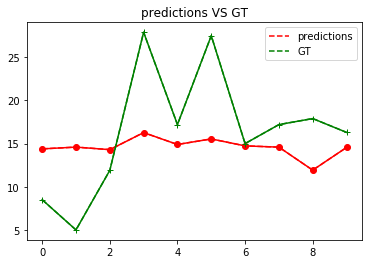

In [35]:
with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names,
     fetch_targets] = fluid.io.load_inference_model(params_dirname, infer_exe) # 载入预训练模型
    batch_size = 10

    infer_reader = paddle.batch(
        paddle.dataset.uci_housing.test(), batch_size=batch_size) # 准备测试集

    infer_data = next(infer_reader())
    infer_feat = numpy.array(
        [data[0] for data in infer_data]).astype("float32") # 提取测试集中的数据
    infer_label = numpy.array(
        [data[1] for data in infer_data]).astype("float32") # 提取测试集中的标签

    assert feed_target_names[0] == 'x'
    results = infer_exe.run(inference_program,
                            feed={feed_target_names[0]: numpy.array(infer_feat)},
                            fetch_list=fetch_targets) # 进行预测
    #打印预测结果和标签并可视化结果
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val)) # 打印预测结果

    print("\nground truth:")
    for idx, val in enumerate(infer_label):
        print("%d: %.2f" % (idx, val)) # 打印标签值

    save_result(results[0], infer_label) # 保存图片